In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
sys.path.append('E:\solar_car_race_strategy\S5')
sys.path.append('/ddn/home/wqpq24')
import S5.Tecplot as TP
from S5.HPC.file_io import write_vel,read_history
from S5.HPC.SolarSim import file_sweep,read_file_sweep,file_sweep_par
from scipy.integrate import cumtrapz

def cal_e_dx(power, velocity, x):
    return np.trapz(power / velocity, x=x)
def cal_e_dt(power,t):
    return np.trapz(power, x=t)
def cal_hist_power(path):
    var = ['Solar/InputPower(W)', 'InclinePower(W)', 'RollingPower(W)',
       'AeroPower(W)', 'ControllerPowerIn(W)', 'BatteryPowerOut(W)']
    print(os.path.basename(path))
    TPDF = TP.TecplotData(path)
    print(TPDF.data.loc[:,var].apply(lambda g: np.trapz(g, x=TPDF.data.loc[:,'DrivingTime(s)'])))
    return TPDF
def add_timestamp(HistTP,startday):
    HistTP.data.loc[:, 'Day'] = HistTP.data['DDHHMMSS'].astype(int).astype(str).str.pad(8, fillchar='0').str[
                                0:2].astype(int)
    startday = pd.to_datetime(startday)
    HistTP.data.loc[:, 'DateTime'] = pd.to_datetime(
        HistTP.data['DDHHMMSS'].astype(int).astype(str).str.pad(8, fillchar='0').str[2:8], format='%H%M%S')
    HistTP.data.loc[:, 'DateTime'] = pd.to_datetime(
        startday.strftime('%Y%m%d') + HistTP.data['DateTime'].dt.strftime('%H%M%S'))
    HistTP.data.loc[:, 'DateTime'] = HistTP.data['DateTime'] + pd.to_timedelta(HistTP.data['Day'] - 1, unit='D')
    return HistTP

In [2]:
path = 'W:\DataStorage\OwenFoo\Completed SolarSim\Wind\\'
file = 'History_tvel_yaw'
H0path = path+file+'0.dat'
H1path = path+file+'1.dat'
H2path = path+file+'2.dat'
H3path = path+file+'3.dat'
H4path = path+file+'4.dat'
H5path = path+file+'5.dat'
H6path = path+file+'6.dat'
H7path = path+file+'7.dat'
Hpathlst = [H1path,H2path,H3path,H4path,H5path,H6path,H7path]


H0 = TP.SSHistory(H0path)
H1 = TP.SSHistory(H1path)
H2 = TP.SSHistory(H2path)
H3 = TP.SSHistory(H3path)
H4 = TP.SSHistory(H4path)
H5 = TP.SSHistory(H5path)
H6 = TP.SSHistory(H6path)
H7 = TP.SSHistory(H7path)

Hlst = [H1,H2,H3,H4,H5,H6,H7]

In [3]:
H1path='E:\solar_car_race_strategy\SolarSim\\1.Const-Vel\History_73.0.dat'
H2path='E:\solar_car_race_strategy\SolarSim\CVX\History-SingleStratComb.dat'
H3path='E:\solar_car_race_strategy\SolarSim\CombStrat\History_CombStratIdeal.dat'
Hpathlst = [H1path,H2path,H3path]
H0path = H1path
H1 = TP.SSHistory(H1path)
H2 = TP.SSHistory(H2path)
H3 = TP.SSHistory(H3path)
Hlst = [H1,H2,H3]
H0 = H1

for H in Hlst:
    H.add_timestamp('20191013')

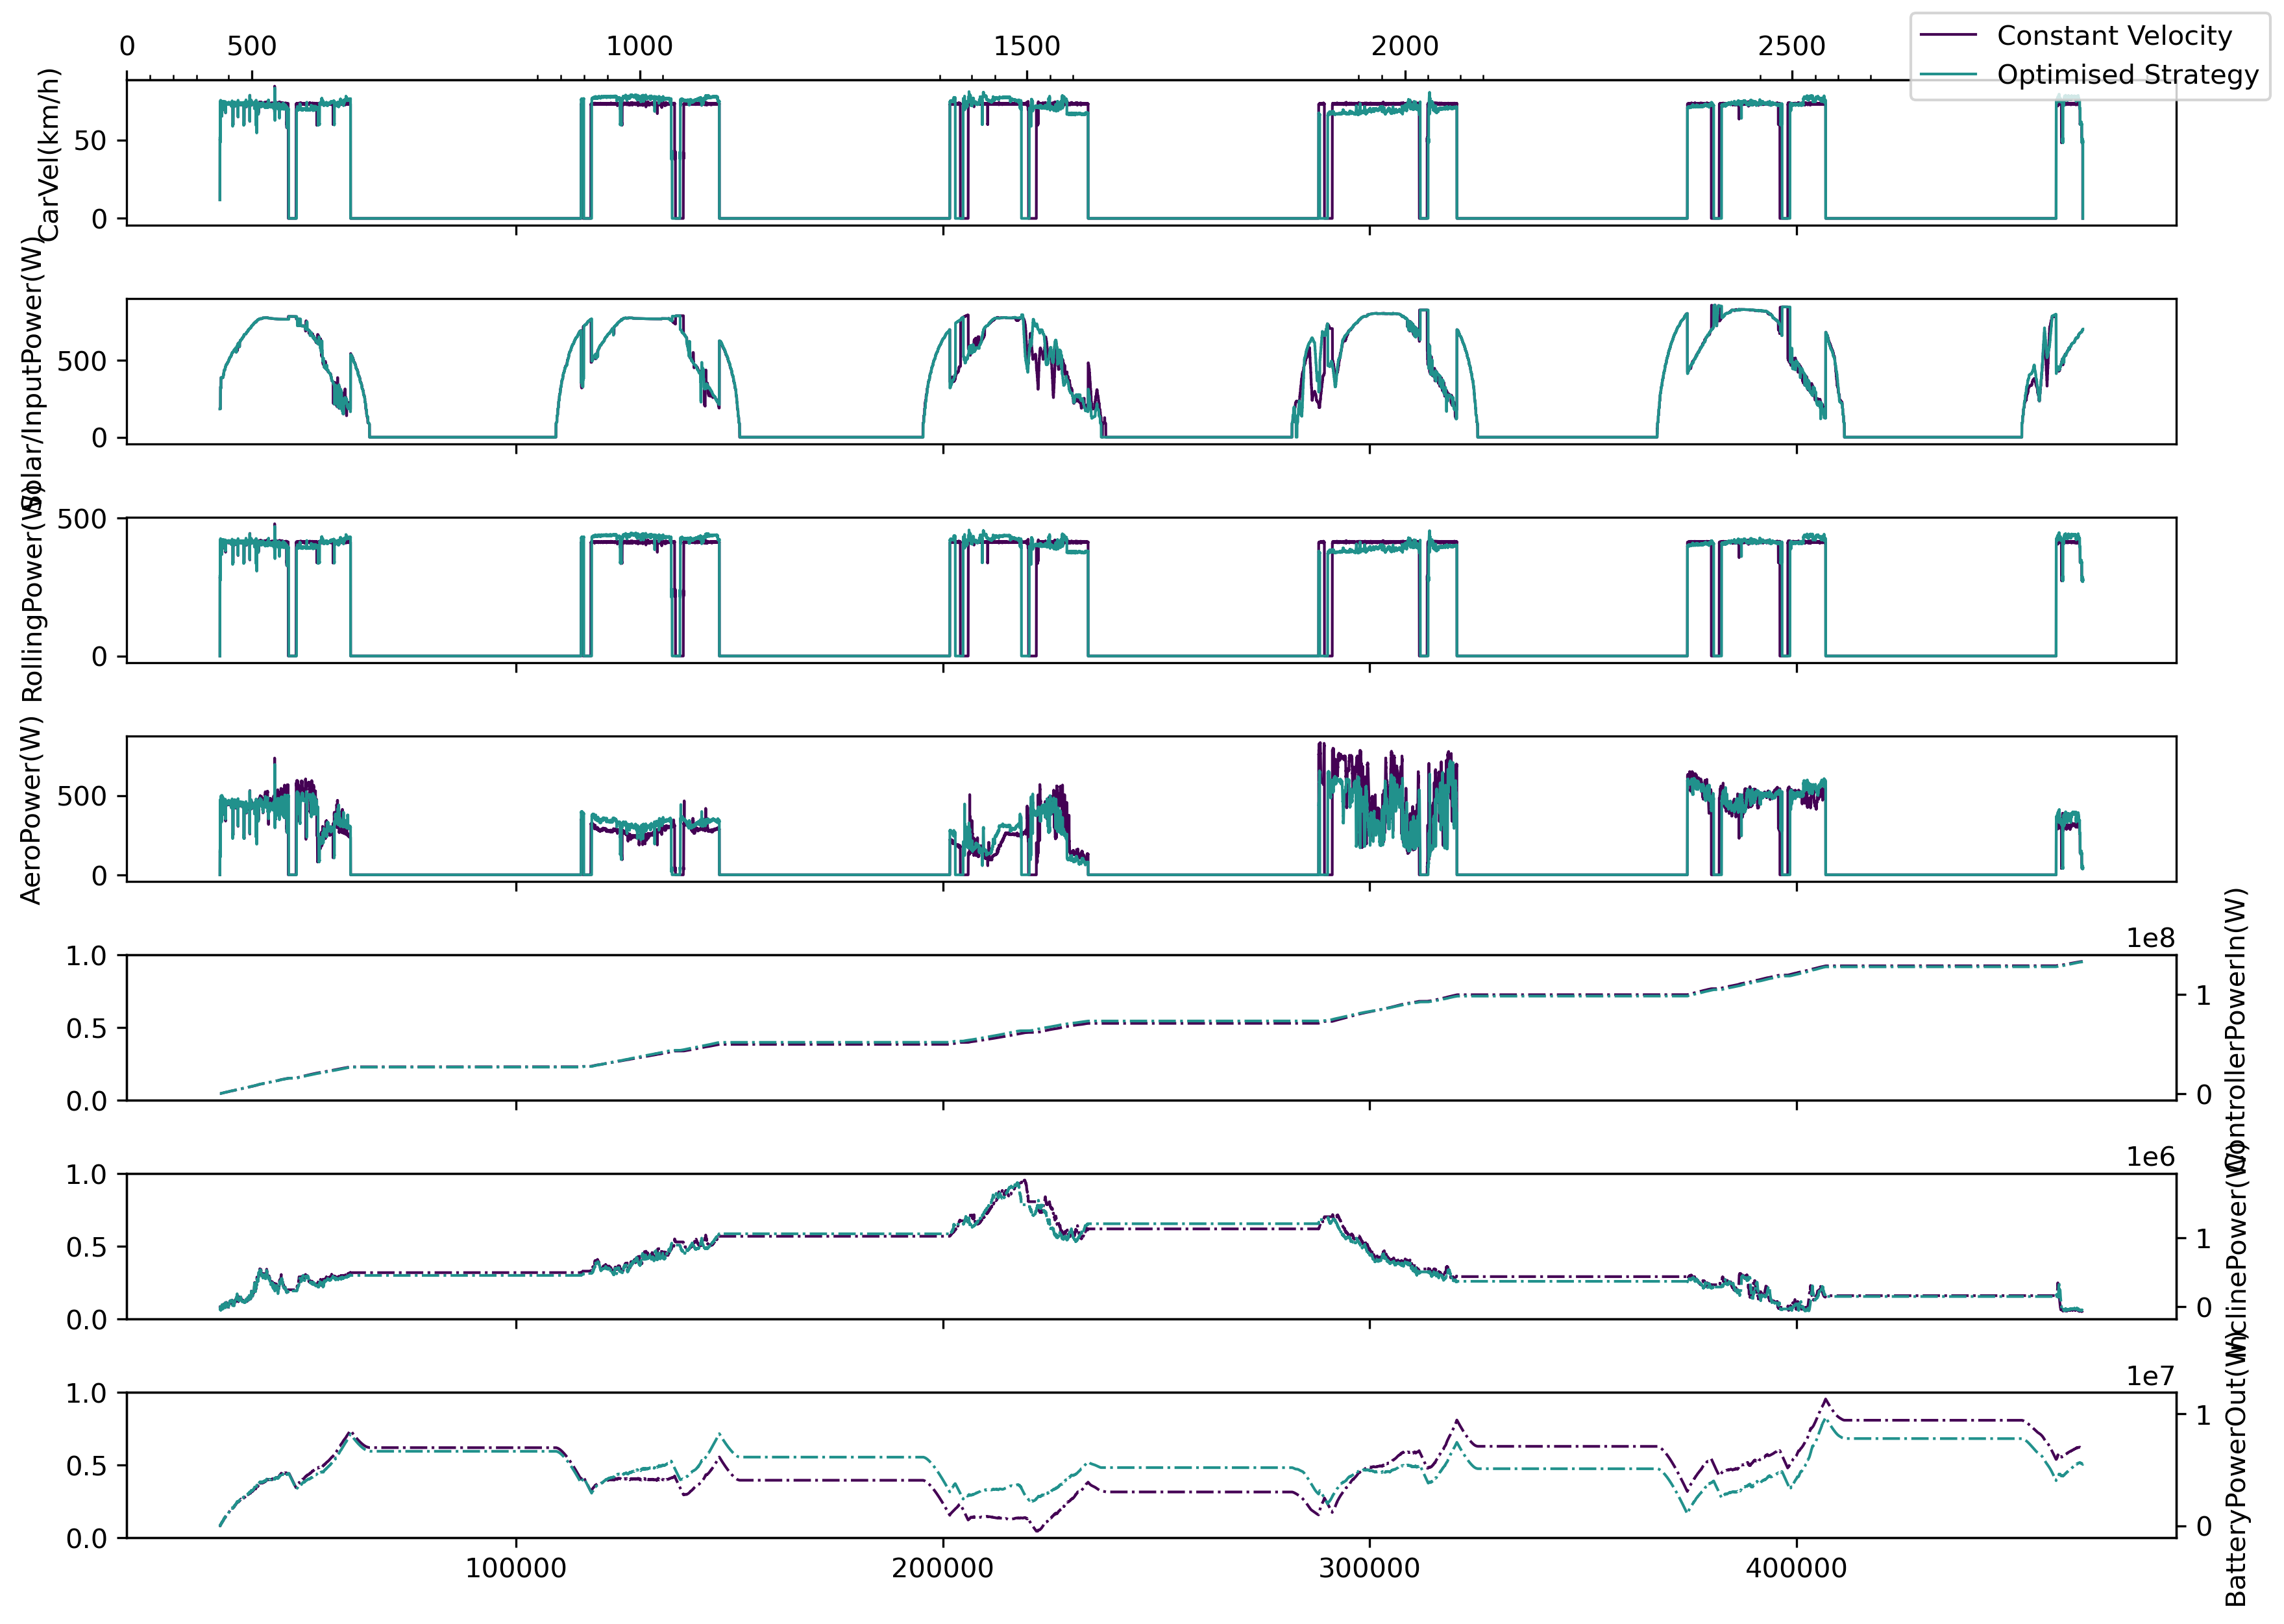

In [7]:
var = ['Solar/InputPower(W)', 'InclinePower(W)', 'RollingPower(W)',
       'AeroPower(W)', 'ControllerPowerIn(W)', 'BatteryPowerOut(W)']

fig, ax = plt.subplots(len(var) + 1, 1, sharex=True)
fig.set_size_inches(11.75, 8.25)
# TODO: colormap
cm = plt.cm.viridis(np.linspace(0, 1, len(Hpathlst)))

i = 0
for v in ['CarVel(km/h)', 'Solar/InputPower(W)', 'RollingPower(W)',
          'AeroPower(W)']:
    H1.data.plot(x='DayAndTime(s)', y=v, ax=ax[i], color=cm[0], linewidth=1, legend=False)
    H2.data.plot(x='DayAndTime(s)', y=v, ax=ax[i], color=cm[1], linewidth=1, legend=False)
    # H3.data.plot(x='DayAndTime(s)', y=v, ax=ax[i], color=cm[2], linewidth=1, legend=False)
    ax[i].set_ylabel(v)
    # if i % 2 == 1:
    #     ax[i].yaxis.tick_right()
    #     ax[i].yaxis.set_label_position("right")
    i += 1

for v in ['ControllerPowerIn(W)', 'InclinePower(W)','BatteryPowerOut(W)']:
    axtwin = ax[i].twinx()
    axtwin.plot(H1.data['DayAndTime(s)'].iloc[:-1], cumtrapz(H1.data[v], H1.data['DayAndTime(s)']), color=cm[0],
               linewidth=1,ls='-.')
    axtwin.plot(H2.data['DayAndTime(s)'].iloc[:-1], cumtrapz(H2.data[v], H2.data['DayAndTime(s)']), color=cm[1],
               linewidth=1,ls='-.')
    # axtwin.plot(H3.data['DayAndTime(s)'].iloc[:-1], cumtrapz(H3.data[v], H3.data['DayAndTime(s)']), color=cm[2],
    #            linewidth=1,ls='-.')
    axtwin.set_ylabel(v)
    # if i % 2 == 1:
    #     axtwin.yaxis.tick_right()
    #     axtwin.yaxis.set_label_position("right")
    i += 1
#     H1.data.plot(x='DayAndTime(s)',y=v,ax=ax[i+1],label=os.path.basename(H1path),color=cm[0],linewidth=1)
#     H2.data.plot(x='DayAndTime(s)',y=v,ax=ax[i+1],label=os.path.basename(H2path),color=cm[1],linewidth=1)


fig.legend(['Constant Velocity', 'Optimised Strategy'])


def forward(x):  # TODO: make sure monotonically increasing
    return np.interp(x, H1.data['DayAndTime(s)'], H1.data['Distance(km)'])


def inverse(x):
    return np.interp(x, H1.data['Distance(km)'], H1.data['DayAndTime(s)'])


secax = ax[0].secondary_xaxis('top', functions=(forward, inverse))
secax.set_xticks(np.arange(0, 3000, 500), minor=False)
secax.set_xticks(np.arange(0, 3000, 100), minor=True)
# plt.setp(secax.get_xticklabels(), rotation=-30, ha="right",
#              rotation_mode="anchor")

fig.dpi = 300
plt.tight_layout()

History_73.0.dat
Solar/InputPower(W)     126410258.839586
InclinePower(W)            -16596.526106
RollingPower(W)          61454227.236985
AeroPower(W)             57031235.382712
ControllerPowerIn(W)     133304126.11134
BatteryPowerOut(W)        6893867.270923
dtype: object
=====delta=from=baseline=====
History_73.0.dat
Solar/InputPower(W)     0.0
InclinePower(W)         0.0
RollingPower(W)         0.0
AeroPower(W)            0.0
ControllerPowerIn(W)    0.0
BatteryPowerOut(W)      0.0
dtype: object
History-SingleStratComb.dat
Solar/InputPower(W)      934566.594863
InclinePower(W)           13072.310776
RollingPower(W)           -2077.208863
AeroPower(W)             -607514.94243
ControllerPowerIn(W)    -448646.456427
BatteryPowerOut(W)     -1383213.049803
dtype: object
History_CombStratIdeal.dat
Solar/InputPower(W)    -5634218.206627
InclinePower(W)           23065.684668
RollingPower(W)           -2800.179632
AeroPower(W)           -4301962.263088
ControllerPowerIn(W)   -5168071.691

C:\Users\USER\AppData\Local\Temp\ipykernel_24348\3018743875.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('\(W\)','').str.replace('Power','')


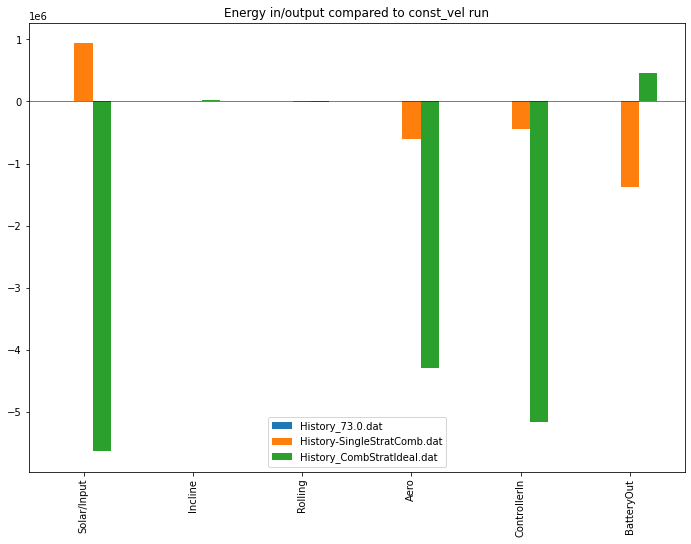

In [8]:
var = ['Solar/InputPower(W)', 'InclinePower(W)', 'RollingPower(W)',
       'AeroPower(W)', 'ControllerPowerIn(W)', 'BatteryPowerOut(W)']
print(os.path.basename(H0path))
H0.data.loc[:,'Day']=H0.data.loc[:,'DDHHMMSS'].astype(int).astype('str').str.zfill(8).str[0:2].astype(int)
df = pd.DataFrame(index=H1.data.Day.unique(),columns=var)
for d in H0.data.Day.unique():
    row = H0.data.loc[H0.data.Day==d,var].apply(lambda g: np.trapz(g, x=H0.data.loc[H0.data.Day==d,'DayAndTime(s)']))
    df.loc[d,:]=row.transpose()
print(baseline := df.sum())
difflst = []
# baseline = 0

print("=====delta=from=baseline=====")
for H,Hpath in zip(Hlst,Hpathlst):
    print(os.path.basename(Hpath))
    H.data.loc[:,'Day']=H.data.loc[:,'DDHHMMSS'].astype(int).astype('str').str.zfill(8).str[0:2].astype(int)
    df = pd.DataFrame(index=H1.data.Day.unique(),columns=var)
    for d in H.data.Day.unique():
        row = H.data.loc[H.data.Day==d,var].apply(lambda g: np.trapz(g, x=H.data.loc[H.data.Day==d,'DayAndTime(s)']))
        df.loc[d,:]=row.transpose()
    print(h := df.sum()-baseline)
    difflst.append(h)

df = pd.concat(difflst,axis=1)
df.columns = [os.path.basename(Hpath) for Hpath in Hpathlst]
df.index = df.index.str.replace('\(W\)','').str.replace('Power','')
ax = df.plot(kind='bar')
ax.axhline(0,c='k',lw = 0.5)
ax.set_title('Energy in/output compared to const_vel run')
ax.figure.set_size_inches(11.75, 8.25)

<AxesSubplot:xlabel='Distance (km)'>

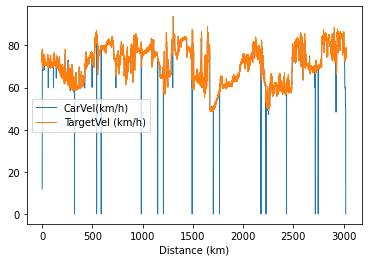

In [6]:
H2path='E:\solar_car_race_strategy\SolarSim\CVX\History_CVX2.1.dat'
H1path = 'W:\DataStorage\OwenFoo\portal_from_hamilton\CVX2.1\History_CVX2.1.dat'
T1path = 'W:\DataStorage\OwenFoo\portal_from_hamilton\CVX2.1\TargetVel.dat'
Weather = 'E:\solar_car_race_strategy\SolarSim\Baseline\Weather-SolCast-N200-20220322.dat'

H1 = TP.SSHistory(H1path)
T1 = TP.TecplotData(T1path)
W = TP.SSWeather(Weather)

ax = H1.data.plot(x='Distance(km)',y='CarVel(km/h)',linewidth=1)
T1.data.plot(x='Distance (km)',y='TargetVel (km/h)',ax=ax,linewidth=1)
# ax2 = ax.twinx()
# W.data.plot(x='Distance (km)',y='DiffuseSun (W/m2)',ax=ax2,color = 'r')
# ax2.set_ylim([0,1400])
# ax.set_ylim([65,75])


<AxesSubplot:xlabel='Distance(km)'>

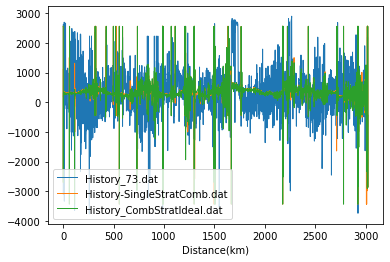

In [15]:

fig,ax = plt.subplots(1)
H1.data.plot(x='Distance(km)',y='BatteryPowerOut(W)',ax=ax,label=os.path.basename(H1path),linewidth=1)
H2.data.plot(x='Distance(km)',y='BatteryPowerOut(W)',ax=ax,label=os.path.basename(H2path),linewidth=1)
H3.data.plot(x='Distance(km)',y='BatteryPowerOut(W)',ax=ax,label=os.path.basename(H3path),linewidth=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_24348\3274894369.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  df.index = df.index.str.replace('\(W\)','').str.replace('Power','')


Text(0.5, 1.0, 'Energy in/output compared to const_vel run')

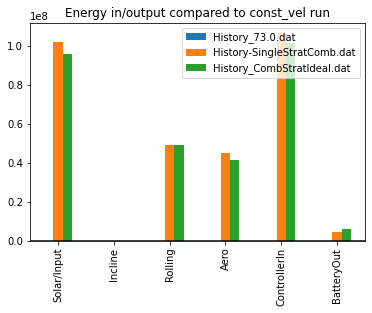

In [9]:
difflst = []
H = H0
bl = H.data.loc[:,var].apply(lambda g: np.trapz(g))
for H in Hlst:
    h = H.data.loc[:,var].apply(lambda g: np.trapz(g))#, x=H.data.loc[H.data.Day==d,'DayAndTime(s)']))
    difflst.append(h-bl)
df = pd.concat(difflst,axis=1)
df.columns = [os.path.basename(Hpath) for Hpath in Hpathlst]
df.index = df.index.str.replace('\(W\)','').str.replace('Power','')
ax = df.plot(kind='bar')
ax.axhline(0,c='k')
ax.set_title('Energy in/output compared to const_vel run')

C:\Users\USER\AppData\Local\Temp\ipykernel_24348\315786708.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(dates.num2date(ax.get_yticks(),tz = pytz.timezone('Australia/Darwin')))


(0.0, 3030.0)

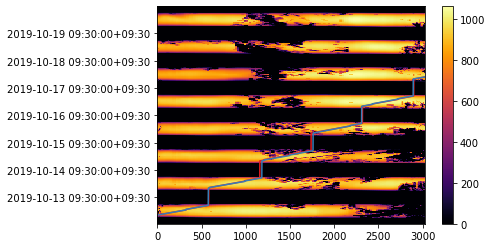

In [10]:
Weather = TP.SSWeather('E:\solar_car_race_strategy\SolarSim\Baseline\Weather-SolCast-N200-20220322.dat')
Weather.addtimestamp(startday="20191013")

direct = Weather.data.loc[:,['DirectSun (W/m2)']].to_numpy()
Dist = np.unique(Weather.data.loc[:,['Distance (km)']].to_numpy())
DateTime = np.unique(Weather.data.loc[:,['DateTime']].to_numpy())
import matplotlib.dates as dates
DateTimenum,Dist = np.meshgrid(dates.date2num(DateTime),Dist)
direct = np.reshape(direct,np.shape(Dist))
import matplotlib.pyplot as plt
import pytz
fig, ax = plt.subplots()
c = ax.pcolormesh(Dist,DateTimenum,direct,cmap='inferno')
cbar = fig.colorbar(c, ax=ax)
ax.set_yticklabels(dates.num2date(ax.get_yticks(),tz = pytz.timezone('Australia/Darwin')))
cm=plt.get_cmap('Set1')
ax.plot(H1.data['Distance(km)'],H1.data['DateTime'],c=cm.colors[0])
ax.plot(H2.data['Distance(km)'],H2.data['DateTime'],c=cm.colors[1])
ax.set_xlim([0,3030])

